In [1]:
import torch
import torchvision.datasets as D
import torchvision.transforms as T
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm, trange
import torch.optim as optim
from d3s.disentangled_model import DisentangledModel
from copy import deepcopy
%matplotlib inline

In [2]:
colors = torch.rand(10, 3)
colors = colors / torch.sum(colors, dim=1, keepdim=True)
colors = colors.reshape(-1, 3, 1, 1)

def modify_image(image, color):
    image = T.ToTensor()(image).repeat(3, 1, 1)
    image = image * color
    return T.ToPILImage()(image)

class ColoredMNIST(Dataset):
    def __init__(self, train=True, transform=None, target_transform=None):
        super().__init__()
        
        self.transform = transform
        self.target_transform = target_transform
        
        mnist = D.MNIST("/cmlscratch/pkattaki/datasets/", train=train, download=True)
        self.targets = mnist.targets.type(torch.LongTensor)
        self.color_labels = torch.randint(0, 10, self.targets.shape)
        
        
        self.data = []
        for i in range(len(mnist)):
            color_label = self.color_labels[i]
            image = mnist[i][0]
            colored_image = modify_image(image, colors[color_label])
            self.data.append(colored_image)
    
    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        color_label = label

        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label, color_label
    
    def __len__(self):
        return len(self.data)

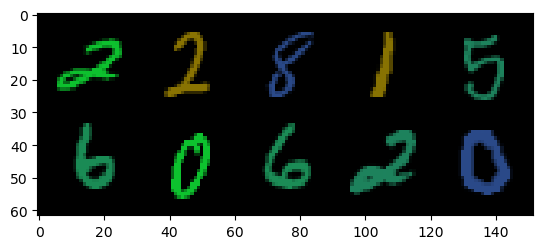

In [3]:
colored_mnist = ColoredMNIST(transform=T.ToTensor())
dataloader = DataLoader(colored_mnist, batch_size=10, shuffle=True)
batch = next(iter(dataloader))[0]
plt.imshow(T.ToPILImage()(make_grid(batch, nrow=5)))

In [4]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 4, 3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.Flatten(),
        )
        self.num_features = 16 * 7 * 7
        self.fc = nn.Linear(self.num_features, num_classes)
        
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [5]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_colored_mnist = ColoredMNIST(train=True, transform=transform)
test_colored_mnist = ColoredMNIST(train=False, transform=transform)

trainloader = DataLoader(train_colored_mnist, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
testloader = DataLoader(test_colored_mnist, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

In [6]:
ce_criterion = nn.CrossEntropyLoss()

def train_base(model, dataloader, num_epochs=50):
    """Vanilla training"""
    model.train()
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for _ in trange(num_epochs, desc="Training"):
        for images, labels, _ in dataloader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = ce_criterion(outputs, labels)
            loss.backward()
            optimizer.step()

@torch.no_grad()
def test_base(model, dataloader):
    model.eval()
    
    total = 0.0
    correct = 0.0
    for images, labels, _ in tqdm(dataloader, desc="Testing"):
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += images.shape[0]
        correct += (predicted == labels).sum().item()
        
    return 100 * correct / total

In [67]:
model = ConvNet()
model.cuda()

train_base(model, trainloader, num_epochs=30)
print(test_base(model, trainloader))
print(test_base(model, testloader))

Testing: 100%|████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 74.44it/s]


99.74


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 63.04it/s]

98.68


In [189]:
class DisentangledFeatureModel(nn.Module):
    def __init__(self, num_fg_features=None, num_bg_features=None, num_fg_classes=10, num_bg_classes=10):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 4, 3, padding=1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(4, 8, 3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.Flatten(),
        )
        self.num_features = 16 * 7 * 7
        
        assert (num_fg_features is not None) ^ (
            num_bg_features is not None
        ), "Must specify exactly one of num_bg_features or num_fg_features"
        if num_bg_features is None:
            num_bg_features = self.num_features - num_fg_features
        if num_fg_features is None:
            num_fg_features = self.num_features - num_bg_features

        self.num_fg_features = num_fg_features
        self.num_bg_features = num_bg_features
        
        self.fg_fc = nn.Linear(self.num_fg_features, num_fg_classes)
        self.bg_fc = nn.Linear(self.num_bg_features, num_bg_classes)
        
        
    def forward(self, x):
        features = self.conv(x)
        fg_features = features[:, :self.num_fg_features]
        bg_features = features[:, -self.num_bg_features:]
        fg_outputs = self.fg_fc(fg_features)
        bg_outputs = self.bg_fc(bg_features)
        
        return fg_outputs, bg_outputs, fg_features, bg_features
        

In [ ]:
from d3s.mine_loss import MINELoss
class MINETrainer:
    def __init__(self, model, alpha=1.0, mine_ma_rate=0.1, lr=1e-3, weight_decay=1e-4, only_disentangle=True) -> None:
        self.model = model
        self.lr = lr
        self.ce_criterion = nn.CrossEntropyLoss()
        self.mine_criterions = {
            "fg": MINELoss(
                feature_dim=self.model.num_fg_features,
                ma_rate=mine_ma_rate,
            ).cuda(),
            "bg": MINELoss(
                feature_dim=self.model.num_bg_features,
                ma_rate=mine_ma_rate,
            ).cuda(),
        }
        self.only_disentangle = only_disentangle
        if self.only_disentangle:
            self.model_optimizer = optim.SGD(
                self.model.disentangle.parameters(),
                lr=lr,
                weight_decay=weight_decay,
            )
            for name, parameter in self.model.named_parameters():
                if "disentangle" not in name:
                    parameter.requires_grad = False
        else:
            self.model_optimizer = optim.SGD(
                self.model.parameters(),
                lr=self.lr,
                weight_decay=weight_decay,
            )
        self._mine_optimizers = None
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.model_optimizer,
            patience=25,
            threshold=1e-3,
            cooldown=100,
            min_lr=1e-4,
        )
        self.alpha = alpha

    @property
    def mine_optimizers(self):
        if self._mine_optimizers is None:
            self._mine_optimizers = {
                "fg": optim.Adam(
                    self.mine_criterions["fg"].parameters(),
                    lr=self.lr,
                ),
                "bg": optim.Adam(
                    self.mine_criterions["bg"].parameters(),
                    lr=self.lr,
                ),
            }
        return self._mine_optimizers

    def reset_mine_optimizers(self):
        self._mine_optimizers = None

    def train(self, batch, optimize_mine):
        if self.only_disentangle:
            self.model.eval()
        else:
            self.model.train()
            
        images, digit_labels, color_labels = batch
        images, digit_labels, color_labels = images.cuda(), digit_labels.cuda(), color_labels.cuda()
        outputs, fg_features, bg_features = self.model(images)

        if optimize_mine:
            self.mine_optimizers["fg"].zero_grad()
            loss = self.mine_criterions["fg"](
                fg_features, color_labels, optimize_T=True
            )
            loss.backward(retain_graph=True)
            self.mine_optimizers["fg"].step()

            self.mine_optimizers["bg"].zero_grad()
            loss = self.mine_criterions["bg"](
                bg_features, digit_labels, optimize_T=True
            )
            loss.backward()
            self.mine_optimizers["bg"].step()
            
        else:
            self.model_optimizer.zero_grad()
            self.reset_mine_optimizers()

            fg_mine_loss = self.mine_criterions["fg"](
                fg_features, color_labels, optimize_T=False
            )
            bg_mine_loss = self.mine_criterions["bg"](
                bg_features, digit_labels, optimize_T=False
            )
            mine_loss = -(fg_mine_loss + bg_mine_loss)

            if not self.only_disentangle:
                ce_loss = self.ce_criterion(outputs, digit_labels)
                total_loss = mine_loss + self.alpha * ce_loss
            else:
                total_loss = mine_loss

            total_loss.backward()
            self.model_optimizer.step()
            self.scheduler.step(total_loss)

            if self.only_disentangle:
                return total_loss.item()
            else:
                return total_loss.item(), ce_loss.item(), mine_loss.item()

In [ ]:
num_epochs = 30
only_disentangle = False
disentangled_model = DisentangledModel(deepcopy(model), num_fg_features=model.num_features // 2).cuda()
mine_trainer = MINETrainer(disentangled_model, only_disentangle=only_disentangle)
switch_every = 1
optimize_mine = True
step = 0
ce_losses = []
mine_losses = []
total_losses = []
for _ in trange(num_epochs):
    for batch in trainloader:
        step_losses = mine_trainer.train(batch, optimize_mine=optimize_mine)
        if not optimize_mine:
            if only_disentangle:
                total_losses.append(step_losses)
            else:
                total_losses.append(step_losses[0])
                ce_losses.append(step_losses[1])
                mine_losses.append(step_losses[2])
        if step % switch_every == 0:
            optimize_mine = not optimize_mine
        step += 1
plt.plot(np.array(total_losses), label="Total loss")
if not only_disentangle:
    plt.plot(np.array(ce_losses), label="CE loss")
    plt.plot(np.array(mine_losses), label="MINE loss")
plt.legend()

In [138]:
@torch.no_grad()
def test_disentangled(model, dataloader):
    model.eval()
    fg_fg_top1 = bg_bg_top1 = fg_bg_top1 = bg_fg_top1 = total = 0
    for batch in tqdm(dataloader, desc="Testing"):
        images, digit_labels, color_labels = batch
        images, digit_labels, color_labels = images.cuda(), digit_labels.cuda(), color_labels.cuda()
        fg_fg_outputs, bg_bg_outputs, fg_bg_outputs, bg_fg_outputs = model(images)
        fg_fg_top1 += (fg_fg_outputs.argmax(dim=1) == digit_labels).sum().item()
        bg_bg_top1 += (bg_bg_outputs.argmax(dim=1) == color_labels).sum().item()
        fg_bg_top1 += (fg_bg_outputs.argmax(dim=1) == digit_labels).sum().item()
        bg_fg_top1 += (bg_fg_outputs.argmax(dim=1) == color_labels).sum().item()
        total += digit_labels.shape[0]
    
    fg_fg_top1 = 100 * fg_fg_top1 / total
    bg_bg_top1 = 100 * bg_bg_top1 / total
    fg_bg_top1 = 100 * fg_bg_top1 / total
    bg_fg_top1 = 100 * bg_fg_top1 / total
    return fg_fg_top1, bg_bg_top1, fg_bg_top1, bg_fg_top1

In [ ]:
outputs_top1, _, _ = test_disentangled(disentangled_model, testloader)
print(f"Full Model Accuracy: {outputs_top1}")

In [162]:
class DisentanglementTestingModel(nn.Module):
    def __init__(self, model, fg_classes=1000, bg_classes=10):
        super().__init__()
        self.model = model
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad_(False)
        self.fg_head = nn.Linear(self.model.num_bg_features, fg_classes)
        self.bg_head = nn.Linear(self.model.num_fg_features, bg_classes)
        self.heads = nn.ModuleList([self.fg_head, self.bg_head])

    def forward(self, x):
        with torch.no_grad():
            fg_outputs, bg_outputs, fg_features, bg_features = self.model(x)
        fg_logits = self.fg_head(bg_features)
        bg_logits = self.bg_head(fg_features)
        return fg_outputs, bg_outputs, fg_logits, bg_logits

In [164]:
class DisentanglementTester:
    def __init__(self, model, lr=1e-3, momentum=0.9, weight_decay=1e-4) -> None:
        self.model = model
        self.ce_criterion = nn.CrossEntropyLoss()

        self.optimizer = optim.SGD(
            self.model.heads.parameters(),
            lr=lr,
            momentum=momentum,
            weight_decay=weight_decay,
        )

    def train(self, batch):
        self.optimizer.zero_grad()
        images, digit_labels, color_labels = batch
        images, digit_labels, color_labels = images.cuda(), digit_labels.cuda(), color_labels.cuda()
        _, _, fg_logits, bg_logits = self.model(images)
        fg_loss = self.ce_criterion(fg_logits, digit_labels)
        bg_loss = self.ce_criterion(bg_logits, color_labels)
        total_loss = fg_loss + bg_loss
        total_loss.backward()
        self.optimizer.step()
        return total_loss.item(), fg_loss.item(), bg_loss.item()

In [ ]:
disentanglement_testing_model = DisentanglementTestingModel(deepcopy(disentangled_model), fg_classes=10, bg_classes=10)
disentanglement_testing_model.cuda()

In [ ]:
num_epochs = 30
disentanglement_tester = DisentanglementTester(disentanglement_testing_model)
step = 0
fg_losses = []
bg_losses = []
total_losses = []
for _ in trange(num_epochs):
    for batch in trainloader:
        total_loss, fg_loss, bg_loss = disentanglement_tester.train(batch)
        
        total_losses.append(total_loss)
        fg_losses.append(fg_loss)
        bg_losses.append(bg_loss)
        
plt.plot(np.array(total_losses), label="Total loss")
plt.plot(np.array(bg_losses), label="FG loss")
plt.plot(np.array(fg_losses), label="BG loss")
plt.legend()

In [ ]:
outputs_top1, fg_top1, bg_top1 = test_disentangled(disentanglement_testing_model, testloader)
print(f"Full Model Accuracy: {outputs_top1}, FG from BG: {fg_top1}, BG from FG: {bg_top1}")

In [ ]:
class AdvTrainer(nn.Module):
    def __init__(self, model, alpha=1.0, fg_classes=1000, bg_classes=10, mine_ma_rate=0.1, lr=1e-3, weight_decay=1e-4) -> None:
        super().__init__()
        self.model = model
        self.lr = lr
        self.ce_criterion = nn.CrossEntropyLoss()
        self.fg_head = nn.Linear(self.model.num_bg_features, fg_classes)
        self.bg_head = nn.Linear(self.model.num_fg_features, bg_classes)
        self.heads = nn.ModuleList([self.fg_head, self.bg_head])
        self._head_optimizers = None
        self.model_optimizer = optim.SGD(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=weight_decay,
        )
        self.alpha = alpha

    @property
    def head_optimizers(self):
        if self._head_optimizers is None:
            self._head_optimizers = {
                "fg": optim.SGD(
                    self.fg_head.parameters(),
                    lr=self.lr,
                ),
                "bg": optim.SGD(
                    self.bg_head.parameters(),
                    lr=self.lr,
                ),
            }
        return self._head_optimizers

    def train(self, batch):
        self.model.train()
            
        images, digit_labels, color_labels = batch
        images, digit_labels, color_labels = images.cuda(), digit_labels.cuda(), color_labels.cuda()
        outputs, fg_features, bg_features = self.model(images)

        
        self.head_optimizers["fg"].zero_grad()
        self.head_optimizers["bg"].zero_grad()
        
        fg_loss = self.ce_criterion(self.fg_head(bg_features), digit_labels)
        fg_loss.backward(retain_graph=True)
        self.head_optimizers["fg"].step()
        
        bg_loss = self.ce_criterion(self.bg_head(fg_features), color_labels)
        bg_loss.backward()
        self.head_optimizers["bg"].step()
        
        self.model_optimizer.zero_grad()
        
        outputs, fg_features, bg_features = self.model(images)
        
        fg_loss = self.ce_criterion(self.fg_head(bg_features), digit_labels)
        bg_loss = self.ce_criterion(self.bg_head(fg_features), color_labels)
        output_loss = self.ce_criterion(outputs, digit_labels)
        
        total_loss = self.alpha * output_loss - fg_loss - bg_loss
        total_loss.backward()
        
        self.model_optimizer.step()

        return total_loss.item(), output_loss.item(), fg_loss.item(), bg_loss.item()

In [ ]:
num_epochs = 30
disentangled_model = DisentangledModel(deepcopy(model), num_fg_features=model.num_features // 2).cuda()
adv_trainer = AdvTrainer(disentangled_model, fg_classes=10, bg_classes=10).cuda()
total_losses = []
output_losses = []
fg_losses = []
bg_losses = []
for _ in trange(num_epochs):
    for batch in trainloader:
        total_loss, output_loss, fg_loss, bg_loss = adv_trainer.train(batch)
        total_losses.append(total_loss)
        output_losses.append(output_loss)
        fg_losses.append(fg_loss)
        bg_losses.append(bg_loss)
        
plt.plot(np.array(total_losses), label="Total loss")
plt.plot(np.array(output_losses), label="Output loss")
plt.plot(np.array(fg_losses), label="FG loss")
plt.plot(np.array(bg_losses), label="BG loss")
plt.legend()

In [ ]:
outputs_top1, _, _ = test_disentangled(disentangled_model, testloader)
print(f"Full Model Accuracy: {outputs_top1}")

In [ ]:
num_epochs = 30
disentanglement_testing_model = DisentanglementTestingModel(deepcopy(disentangled_model), fg_classes=10, bg_classes=10)
disentanglement_testing_model.cuda()
disentanglement_tester = DisentanglementTester(disentanglement_testing_model)
step = 0
fg_losses = []
bg_losses = []
total_losses = []
for _ in trange(num_epochs):
    for batch in trainloader:
        total_loss, fg_loss, bg_loss = disentanglement_tester.train(batch)
        
        total_losses.append(total_loss)
        fg_losses.append(fg_loss)
        bg_losses.append(bg_loss)
        
plt.plot(np.array(total_losses), label="Total loss")
plt.plot(np.array(bg_losses), label="FG loss")
plt.plot(np.array(fg_losses), label="BG loss")
plt.legend()

In [ ]:
outputs_top1, fg_top1, bg_top1 = test_disentangled(disentanglement_testing_model, testloader)
print(f"Full Model Accuracy: {outputs_top1}, FG from BG: {fg_top1}, BG from FG: {bg_top1}")

In [214]:
def create_mlp_discriminator(feature_dim):
    layers = []
    while feature_dim != 1:
        layers.extend([nn.Linear(feature_dim, feature_dim // 2), nn.LeakyReLU(negative_slope=0.1)])
        feature_dim //= 2
    return nn.Sequential(*layers[:-1])

class WassersteinTrainer(nn.Module):
    def __init__(self, model, alpha=1.0, fg_classes=1000, bg_classes=10, lr=1e-4, lamb=10, weight_decay=1e-4, label_vector_dim=50) -> None:
        super().__init__()
        self.model = model
        self.lr = lr
        self.ce_criterion = nn.CrossEntropyLoss()
        self.fg_discriminator = create_mlp_discriminator(self.model.num_fg_features + label_vector_dim)
        self.bg_discriminator = create_mlp_discriminator(self.model.num_bg_features + label_vector_dim)
        
        self.register_buffer("fg_label_matrix", torch.randn(fg_classes, label_vector_dim))
        self.register_buffer("bg_label_matrix", torch.randn(bg_classes, label_vector_dim))
        
        self._discriminator_optimizers = None
        self.model_optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.lr,
            betas=(0, 0.9),
        )
        self.alpha = alpha
        self.lamb = lamb
        self.count = 0
        self.train_discriminators = True
        self.model_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.model_optimizer, 100, eta_min=5e-4)
        self.discriminator_schedulers = [optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, eta_min=5e-4) for optimizer in list(self.discriminator_optimizers.values())] 

    @property
    def discriminator_optimizers(self):
        if self._discriminator_optimizers is None:
            self._discriminator_optimizers = {
                "fg": optim.Adam(
                    self.fg_discriminator.parameters(),
                    lr=self.lr,
                    betas=(0, 0.9),
                ),
                "bg": optim.Adam(
                    self.bg_discriminator.parameters(),
                    lr=self.lr,
                    betas=(0, 0.9)
                ),
            }
        return self._discriminator_optimizers
    
    def cat_features_labels(self, features, label_vectors):
        return torch.cat((features, label_vectors), dim=1)
    
    def compute_discriminator(self, features, labels, discriminator, label_matrix):
        label_vectors = label_matrix[labels]
        x_f_l = self.cat_features_labels(features, label_vectors)
        return discriminator(x_f_l)
    
    def shuffle(self, x):
        return x[torch.randperm(x.shape[0])]
    
    def compute_discriminator_loss(self, features, labels, discriminator, label_matrix):
        label_vectors = label_matrix[labels]
        x_f_l = self.cat_features_labels(features, label_vectors)
        d_f_l = discriminator(x_f_l)
        shuffled_label_vectors = self.shuffle(label_vectors)
        x_f_shuffled_l = self.cat_features_labels(features, shuffled_label_vectors)
        d_f_shuffled_l = discriminator(x_f_shuffled_l)
        epsilons = torch.rand_like(x_f_l)
        x_f_interpolated_l = epsilons * x_f_l + (1 - epsilons) * x_f_shuffled_l
        d_f_interpolated_l = discriminator(x_f_interpolated_l)
        gradient = torch.autograd.grad(
                d_f_interpolated_l,
                x_f_interpolated_l,
                grad_outputs=torch.ones_like(d_f_interpolated_l),
                create_graph=True,
                retain_graph=True,
            )[0]
        gradient_penalty = (gradient.norm(2, dim=1) - 1) ** 2
        return (d_f_l - d_f_shuffled_l + self.lamb * gradient_penalty).mean()

    def train(self, batch):
        self.model.train()
        
        images, digit_labels, color_labels = batch
        images, digit_labels, color_labels = images.cuda(), digit_labels.cuda(), color_labels.cuda()
        self.count += 1
        
        if self.train_discriminators:
            _, _, fg_features, bg_features = self.model(images)
            self.discriminator_optimizers["fg"].zero_grad()
            fg_discriminator_loss = self.compute_discriminator_loss(
                fg_features,
                color_labels,
                self.fg_discriminator,
                self.fg_label_matrix,
            )
            fg_discriminator_loss.backward(retain_graph=True)
            self.discriminator_optimizers["fg"].step()
            
            
            self.discriminator_optimizers["bg"].zero_grad()
            bg_discriminator_loss = self.compute_discriminator_loss(
                bg_features,
                digit_labels,
                self.bg_discriminator,
                self.bg_label_matrix,
            )
            bg_discriminator_loss.backward()
            self.discriminator_optimizers["bg"].step()
            
            for scheduler in self.discriminator_schedulers:
                scheduler.step()
            
#             if fg_discriminator_loss + bg_discriminator_loss < 1e-4 or self.count >= 10:
#                 self.train_discriminators = False
#                 self.count = 0
            if self.count >= 5:
                self.train_discriminators = False
                self.count = 0
                        
            return fg_discriminator_loss.item(), bg_discriminator_loss.item()
        else:
            fg_outputs, bg_outputs, fg_features, bg_features = self.model(images)
            self.model_optimizer.zero_grad()
            
            d_fg_bg = self.compute_discriminator(fg_features, color_labels, self.fg_discriminator, self.fg_label_matrix)
            d_fg_shuffled_bg = self.compute_discriminator(fg_features, self.shuffle(color_labels), self.fg_discriminator, self.fg_label_matrix)
            
            fg_loss = (d_fg_shuffled_bg - d_fg_bg).mean()
            fg_loss.backward(retain_graph=True)
            
            d_bg_fg = self.compute_discriminator(bg_features, digit_labels, self.bg_discriminator, self.bg_label_matrix)
            d_bg_shuffled_fg = self.compute_discriminator(bg_features, self.shuffle(digit_labels), self.bg_discriminator, self.bg_label_matrix)
            
            bg_loss = (d_bg_shuffled_fg - d_bg_fg).mean()
            bg_loss.backward(retain_graph=True)
            
            ce_loss = self.alpha * (self.ce_criterion(fg_outputs, digit_labels) + self.ce_criterion(bg_outputs, color_labels))
            ce_loss.backward()
            
            self.model_optimizer.step()
            self.model_scheduler.step()
            
#             if fg_loss + bg_loss < 1e-4 or self.count >= 10:
#                 self.train_discriminators = True
#                 self.count = 0
            self.train_discriminators = True
            
            return fg_loss.item(), bg_loss.item(), ce_loss.item()

In [252]:
num_epochs = 50
alpha = 1.0
# disentangled_model = DisentangledFeatureModel(num_fg_features=16 * 7 * 7 - 50).cuda()
wasserstein_trainer = WassersteinTrainer(deepcopy(base_disentangled_model), alpha=alpha, lr=5e-3, fg_classes=10, bg_classes=10).cuda()
step = 1
fg_losses = []
bg_losses = []
ce_losses = []
fg_discriminator_losses = []
bg_discriminator_losses = []
for _ in trange(num_epochs):
    for batch in trainloader:
        losses = wasserstein_trainer.train(batch)
        if len(losses) == 2:
            fg_discriminator_losses.append(losses[0])
            bg_discriminator_losses.append(losses[1])
        else:
            fg_losses.append(losses[0])
            bg_losses.append(losses[1])
            ce_losses.append(losses[2])           
        step += 1

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [04:15<00:00,  5.10s/it]


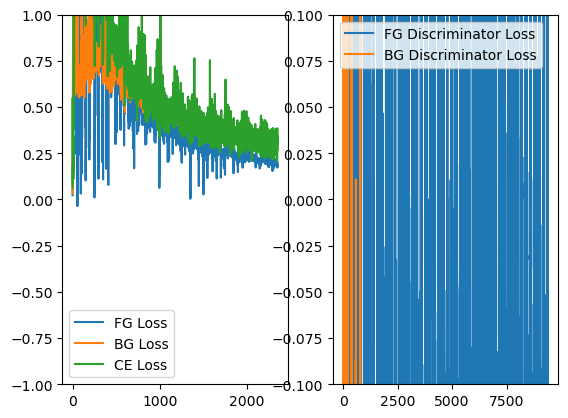

In [253]:
_, ax = plt.subplots(1, 2)
ax[0].plot(np.array(fg_losses), label="FG Loss")
ax[0].plot(np.array(bg_losses), label="BG Loss")
ax[0].plot(np.array(ce_losses), label="CE Loss")
ax[0].set_ylim([-1, 1])
ax[0].legend()
ax[1].plot(np.array(fg_discriminator_losses), label="FG Discriminator Loss")
ax[1].plot(np.array(bg_discriminator_losses), label="BG Discriminator Loss")
ax[1].set_ylim([-1e-1, 1e-1])
ax[1].legend()

In [254]:
fg_fg_top1, bg_bg_top1, _, _ = test_disentangled(base_disentangled_model, testloader)
print(f"FG from FG: {fg_fg_top1}, BG from BG: {bg_bg_top1}")

Testing: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 56.47it/s]

FG from FG: 98.22, BG from BG: 97.42


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [01:37<00:00,  3.23s/it]


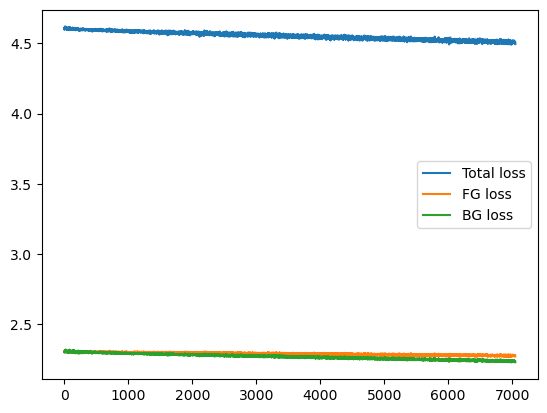

In [255]:
num_epochs = 30
disentanglement_testing_model = DisentanglementTestingModel(deepcopy(disentangled_model), fg_classes=10, bg_classes=10)
disentanglement_testing_model.cuda()
disentanglement_tester = DisentanglementTester(disentanglement_testing_model)
step = 0
fg_losses = []
bg_losses = []
total_losses = []
for _ in trange(num_epochs):
    for batch in trainloader:
        total_loss, fg_loss, bg_loss = disentanglement_tester.train(batch)
        
        total_losses.append(total_loss)
        fg_losses.append(fg_loss)
        bg_losses.append(bg_loss)
        
plt.plot(np.array(total_losses), label="Total loss")
plt.plot(np.array(bg_losses), label="FG loss")
plt.plot(np.array(fg_losses), label="BG loss")
plt.legend()

In [256]:
fg_fg_top1, bg_bg_top1, fg_bg_top1, bg_fg_top1 = test_disentangled(disentanglement_testing_model, testloader)
print(f"FG from FG: {fg_fg_top1}, BG from BG: {bg_bg_top1}, FG from BG: {fg_bg_top1}, BG from FG: {bg_fg_top1}")

Testing: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 58.60it/s]

FG from FG: 98.62, BG from BG: 97.36, FG from BG: 21.44, BG from FG: 11.35


In [230]:
torch.save({"model": disentangled_model.state_dict()}, "colored_mnist_disentangled_model.pt")

In [233]:
def train_disentangled(model, dataloader, num_epochs=50):
    model.train()
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for _ in trange(num_epochs, desc="Training"):
        for images, digit_labels, color_labels in dataloader:
            images, digit_labels, color_labels = images.cuda(), digit_labels.cuda(), color_labels.cuda()
            optimizer.zero_grad()
            fg_outputs, bg_outputs, _, _ = model(images)
            loss = ce_criterion(fg_outputs, digit_labels) + ce_criterion(bg_outputs, color_labels)
            loss.backward()
            optimizer.step()

In [241]:
num_epochs = 50
base_disentangled_model = DisentangledFeatureModel(num_fg_features=16 * 7 * 7 - 50).cuda()
wasserstein_trainer = train_disentangled(base_disentangled_model, trainloader)

Training: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [02:53<00:00,  3.47s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [01:39<00:00,  3.33s/it]


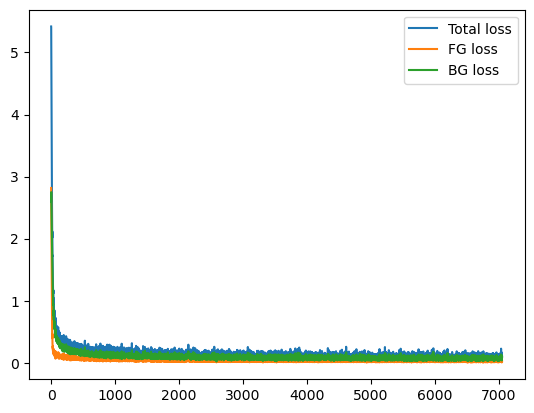

In [257]:
num_epochs = 30
disentanglement_testing_model = DisentanglementTestingModel(deepcopy(base_disentangled_model), fg_classes=10, bg_classes=10)
disentanglement_testing_model.cuda()
disentanglement_tester = DisentanglementTester(disentanglement_testing_model)
step = 0
fg_losses = []
bg_losses = []
total_losses = []
for _ in trange(num_epochs):
    for batch in trainloader:
        total_loss, fg_loss, bg_loss = disentanglement_tester.train(batch)
        
        total_losses.append(total_loss)
        fg_losses.append(fg_loss)
        bg_losses.append(bg_loss)
        
plt.plot(np.array(total_losses), label="Total loss")
plt.plot(np.array(bg_losses), label="FG loss")
plt.plot(np.array(fg_losses), label="BG loss")
plt.legend()

In [258]:
fg_fg_top1, bg_bg_top1, fg_bg_top1, bg_fg_top1 = test_disentangled(disentanglement_testing_model, testloader)
print(f"FG from FG: {fg_fg_top1}, BG from BG: {bg_bg_top1}, FG from BG: {fg_bg_top1}, BG from FG: {bg_fg_top1}")

Testing: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 55.15it/s]

FG from FG: 98.22, BG from BG: 97.42, FG from BG: 97.94, BG from FG: 98.85


In [237]:
disentangled_model = DisentangledFeatureModel(num_fg_features=16 * 7 * 7 - 50).cuda()
disentangled_model.load_state_dict(torch.load("/cmlscratch/pkattaki/void/d3s/d3s/logs/train_disentanglement/wasserstein/colored_mnist_disentangled_model.pt")["model"])

<All keys matched successfully>